# Import

In [1]:
# Agent
import random
import numpy as np
from collections import deque
from tensorflow.keras import models, layers, optimizers, activations, losses

# Utils

# Training and Evaluating
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames
import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

# Remove this after changing the model

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# DQN Agent

In [2]:
class DQNAgent():
    """
    Represents a Deep Q-Network(DQN) agent
    """
    def __init__(self, state_size, action_size, gamma = 0.95,epsilon=0.5, epsilon_min = 0.01, epsilon_decay = 0.98, learning_rate = 0.001, buffer_size = 4098):
        """
        Creates a Deep Q-Networks (DQN) agent.

        :param state_size: number of dimensions of the feature vector of the state.
        :type state_size: int.
        :param action_size: number of actions.
        :type action_size: int.
        :param gamma: discount factor.
        :type gamma: float.
        :param epsilon: epsilon used in epsilon-greedy policy.
        :type epsilon: float.
        :param epsilon_min: minimum epsilon used in epsilon-greedy policy.
        :type epsilon_min: float.
        :param epsilon_decay: decay of epsilon per episode.
        :type epsilon_decay: float.
        :param learning_rate: learning rate of the action-value neural network.
        :type learning_rate: float.
        :param buffer_size: size of the experience replay buffer.
        :type buffer_size: int.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.model = self.make_model()
        
    def make_model(self):
        """
        Makes the action-value neural network model using Keras.

        :return: action-value neural network.
        :rtype: Keras' model.
        """
        
        # Choose Best Model to Problem
        model = models.Sequential()
        # TODO Input_Shape
        model.add(layers.Conv2D(32,(8,8),strides=(4,4),activation='relu',input_shape = (state_size[0],state_size[1],state_size[2])))
        model.add(layers.Conv2D(64,(4,4),strides=(2,2),activation='relu'))
        model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation = 'relu'))
        model.add(layers.Dense(256, activation = 'relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss=losses.mse,
                      optimizer=optimizers.Adam(lr=self.learning_rate))
        model.summary()
        return model
    
    def act(self, state):
        """
        Chooses an action using an epsilon-greedy policy.

        :param state: current state.
        :type state: NumPy array with dimension (1, 2).
        :return: chosen action.
        :rtype: int.
        """
        action_value = self.model.predict(state)
        gr_action = np.argmax(action_value)
        p = np.random.rand()
        if p >= self.epsilon:
            return gr_action
        else:
            num_actions = action_value.shape[1]
            action = np.random.randint(num_actions)
            return action
    
    def append_experience(self, state, action, reward, next_state, done):
        """
        Appends a new experience to the replay buffer (and forget an old one if the buffer is full).

        :param state: state.
        :type state: NumPy array with dimension (1, 2).
        :param action: action.
        :type action: int.
        :param reward: reward.
        :type reward: float.
        :param next_state: next state.
        :type next_state: NumPy array with dimension (1, 2).
        :param done: if the simulation is over after this experience.
        :type done: bool.
        """
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        """
        Learns from memorized experience.

        :param batch_size: size of the minibatch taken from the replay buffer.
        :type batch_size: int.
        :return: loss computed during the neural network training.
        :rtype: float.
        """
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if not done:
                target[0][action] = reward + self.gamma * np.max(self.model.predict(next_state)[0])
            else:
                target[0][action] = reward
            # Filtering out states and targets for training
            states.append(state[0])
            targets.append(target[0])
        history = self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)
        # Keeping track of loss
        loss = history.history['loss'][0]
        return loss
    
    def load(self, name):
        """
        Loads the neural network's weights from disk.

        :param name: model's name.
        :type name: str.
        """
        self.model.load_weights(name)
    
    def save(self, name):
        """
        Saves the neural network's weights to disk.

        :param name: model's name.
        :type name: str.
        """
        self.model.save_weights(name)
    
    def update_epsilon(self):
        """
        Updates the epsilon used for epsilon-greedy action selection.
        """
        self.epsilon *= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

# Utils

In [3]:
# Preprocess frames

def preprocess_frame(frame):
    # gray scale
    gray = rgb2gray(frame)
    
    # crop screen
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

In [4]:
# Stack_frames

stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

In [5]:
def reward_engineering_space_invaders(state, reward, next_state):
    """
    Makes reward engineering to allow faster training in the Mountain Car environment.

    :param state: state.
    :type state: NumPy array with dimension (1, 2).
    :param action: action.
    :type action: int.
    :param reward: original reward.
    :type reward: float.
    :param next_state: next state.
    :type next_state: NumPy array with dimension (1, 2).
    :param done: if the simulation is over after this experience.
    :type done: bool.
    :return: modified reward for faster training.
    :rtype: float.
    """
    # Todo: implement reward engineering
    r_modified = reward
    return r_modified

# Training DQN

In [6]:
### MODEL HYPERPARAMETERS
env = gym.make("ALE/SpaceInvaders-v5")
state_size = [110, 84, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 6 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
NUM_EPISODES = 50  # Number of episodes used for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
epsilon = 1.0            # exploration probability at start
epsilon_min = 0.01            # minimum exploration probability 
epsilon_decay = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate
buffer_size = 4096

### MEMORY HYPERPARAMETERS
# pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
# memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

fig_format = 'eps'

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tf.compat.v1.disable_eager_execution()

# Creating the DQN agent
agent = DQNAgent(state_size, action_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, buffer_size)

if os.path.exists('space_invaders.h5'):
    print('Loading previus learning session.')
    agent.load("space_invaders.h5")
else:
    print('Previus session not found')
done = False

In [ ]:
# Testing Env
env = gym.make("ALE/SpaceInvaders-v5", render_mode='human')
eps = 5
for ep in range(1, eps+1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = random.choice([0,1,2,3,4,5])
        n_state, reward, done, info = env.step(action)
        score += reward
    print("Episode:{} Score:{}".format(ep, score))
env.close()


In [ ]:
for episodes in range(1, NUM_EPISODES + 1):
    # Reset the environment
    state = env.reset()
    # TODO:This reshape is needed to keep compatibility with Keras
    #state = np.reshape(state, [1, state_size])
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    state = np.expand_dims(state, axis=0) # EXPANDING STATE TO GET RIGHT IN TRAINING
    print(state.shape)
    # Cumulative reward is the return since the beginning of the episode
    cumulative_reward = 0.0
    while not done:
        # Select action
        action = agent.act(state)
        # Take action, observe reward and new state
        next_state, reward, done, _ = env.step(action)
        # TODO:Reshaping to keep compatibility with Keras
        #next_state = np.reshape(next_state, [1, state_size])
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        next_state = np.expand_dims(next_state, axis=0) # EXPANDING STATE TO GET RIGHT IN TRAINING
        # Making reward engineering to allow faster training
        reward = reward_engineering_space_invaders(state, reward, next_state)
        # Appending this experience to the experience replay buffer
        agent.append_experience(state, action, reward, next_state, done)
        state = next_state
        # Accumulate reward
        cumulative_reward = agent.gamma * cumulative_reward + reward
        if done:
            print("episode: {}/{}, time: {}, score: {:.6}, epsilon: {:.3}"
                  .format(episodes, NUM_EPISODES, time, cumulative_reward, agent.epsilon))
            break
        # We only update the policy if we already have enough experience in memory
        if len(agent.replay_buffer) > 2 * batch_size:
            loss = agent.replay(batch_size)
    return_history.append(cumulative_reward)
    agent.update_epsilon()
    # Every 10 episodes, update the plot for training monitoring
    if episodes % 20 == 0:
        plt.plot(return_history, 'b')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.show(block=False)
        plt.pause(0.1)
        plt.savefig('dqn_training.' + fig_format, fig_format=fig_format)
        # Saving the model to disk
        agent.save("space_invaders.h5")
plt.pause(1.0)

# Evaluating DQN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 9, 64)         32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 7, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 4480)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2294272   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

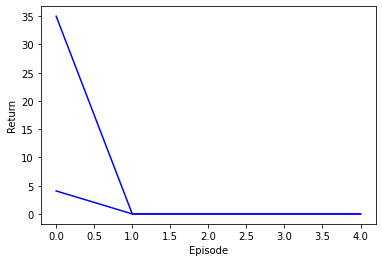

In [7]:
def plot_point(point_list, style):
    x = []
    y = []
    for point in point_list:
        x.append(point[0])
        y.append(point[1])
    plt.plot(x,y,style)


NUM_EPISODES = 5 # Number of episodes used for evaluation
fig_format = 'eps'
# Needs to be commented to enable training with GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

tf.compat.v1.disable_eager_execution()


env = gym.make("ALE/SpaceInvaders-v5", render_mode='human')
state_size = [110,84,4]
action_size = env.action_space.n

# DQN Agent with Greedy Policy(For Evaluation)
agent = DQNAgent(state_size, action_size, epsilon=0.0, epsilon_min=0.0)


# Checking if weights from previous learning session exists
if os.path.exists('space_invaders.h5'):
    print('Loading previus learning session.')
    agent.load("space_invaders.h5")
else:
    print('Unable to evaluate without traininig')
    exit(-1)
return_history = []
score_history = []

done = False

for episodes in range(1, NUM_EPISODES + 1):
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    state = np.expand_dims(state, axis=0) # EXPANDING STATE TO GET RIGHT IN TRAINING
    score= 0.0
    cumulative_reward = 0.0
    while not done:
        action = agent.act(state)
        
        n_state, reward, done, _ = env.step(action)
        
        #TODO Transform n_state
        n_state, stacked_frames = stack_frames(stacked_frames, n_state, False)
        n_state = np.expand_dims(n_state, axis=0) # EXPANDING STATE TO GET RIGHT IN TRAINING
        
        score += reward
        # TODO Implementing reward engineering
        
        state = n_state
        cumulative_reward = agent.gamma * cumulative_reward + reward
    print("episode: {}/{}, score: {:.6}, reward: {:.6}, epsilon: {:.3}"
                  .format(episodes, NUM_EPISODES, score, cumulative_reward, agent.epsilon))
    return_history.append(cumulative_reward)
    score_history.append(score)

print('Mean score: ', np.mean(score_history))
print('Mean return: ', np.mean(return_history))

# Plots score history
plt.plot(score_history, 'b')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.savefig('dqn_evaluation_score.' + fig_format, fig_format=fig_format)

# Plots return history
plt.plot(return_history, 'b')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.savefig('dqn_evaluation_reward.' + fig_format, fig_format=fig_format)